## Customer Model with Reduced Features
---

With Customer Risk model feature outgrowning machine size, let's find ways to circumvent this issue.

In the previous notebook 4.3, we listed 4 options
* break data by chunks
* sample ids
* build model with reduced features
* switch to distributed computing

Let's address option 3 here.

A couple variations
* with/without indeterminate
* old/new indeterminate
* monotonic constraints
* weighing by indeterminate classes...


In [38]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import lightgbm as lgb
import src.monitoring.utils as mu
import src.monitoring.monitoring as mntr
import rdsutils.score_alignment as sa

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data
---

In [2]:
mmonth = "202103"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"
train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_20201201_scored.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_20201201_scored.parquet"))

In [3]:
# mmonth = "202103"
# s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"

# train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_20190201_20201130.parquet"))
# test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_20201201.parquet"))

<AxesSubplot:>

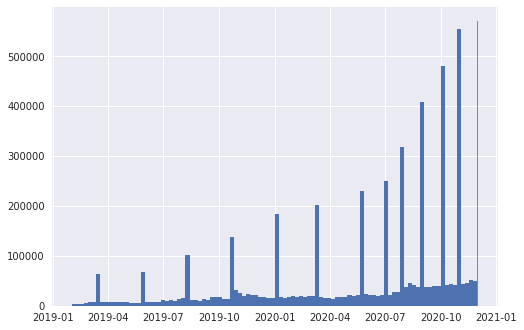

In [4]:
train_df.sample_date.hist(bins=100)
test_df.sample_date.hist(bins=1)

In [5]:
# def build_indeterminate(df):
#     return ((pd.to_datetime(df["dtc"]) <= df["sample_date"])
#             | (df["last_unrestricted_date"] <= df["sample_date"])
#             | (df["chg_wrt_off_date"] <= df["sample_date"])
#             | (df["target"] & (df["latest_acc_bal"] > 0))
#             | (
#                 ~df["target"] & (~df["chg_wrt_off_date"].isna())
#                 | (df["latest_acc_bal"] < 0)
#                 | (
#                     df["closed_reason"].isin(
#                         [
#                             "Closed by SoFi - Risk Request",
#                             "Closed by SoFi - Charge-Off / Write-Off",
#                         ]
#                     )
#                 )
#                 | (df["restricted_reason"].str.startswith("No"))
#             ))
   
# train_df["indeterminate"] = build_indeterminate(train_df)
# test_df["indeterminate"] = build_indeterminate(test_df)
train_df[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.554642
        True             0.412082
True    False            0.002912
        True             0.030365
dtype: float64

In [6]:
train_df.indeterminate.value_counts()

False    2627855
True     2085333
Name: indeterminate, dtype: int64

In [7]:
train_df.target.value_counts(normalize=True), test_df.target.value_counts(normalize=True)

(False    0.966724
 True     0.033276
 Name: target, dtype: float64,
 False    0.988956
 True     0.011044
 Name: target, dtype: float64)

### Select Features
---

In [8]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score',  # giact_time_since_last_link removed 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    # df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

In [9]:
train_df = preprocess(train_df)
test_df = preprocess(test_df)

In [10]:
# features to keep
cols_raw_reduced = ['address_risk_score', 'age_money_account', 'all7120', 
                    'all8220', 'bcc7120', 'credit_card_loan_amount', 
                    'dollar_val_dd', 'dollar_val_returns', 'dollar_val_returns_3d',
                    'education_loan_amount', 'email_risk_score', 'first_deposit_amount', 
                    'fraud_score_1', 'fraud_score_2', 'giact_nr_decline', 
                    'giact_nr_other', 'iln5520', 'iqt9413', 'iqt9415', 
                    'lag_acc_open_first_transaction', 'name_address_correlation',
                    'name_email_correlation', 'name_phone_correlation', 
                    'nr_direct_deposits', 'nr_past_transactions', 'pct_returned_deposits',
                    'phone_risk_score', 'sum_deposits_10d', 'time_since_last_transaction', 
                    'total_tradelines_open', 'transaction_as_pct_of_balance', 'vantage_score']
# removed features
# giact_time_since_last_link, max_withdrawals_30d, nr_returns_30d
# max_deposits_30d, mean_account_balance_30d, nr_trans_ratio, bal_ratio

cols_encoded_reduced = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features_reduced = cols_raw_reduced + cols_encoded_reduced

### Refit
---

In [96]:
seed = 15556
print(seed)
    
scale_by_bad_rate = False
indeterminate_col = None # "indeterminate"  or None

params = {
        "objective" : "binary",
        "metric" : "auc",
        "boosting": 'gbdt',
        "num_iterations": 1400,  # 1400, 200
        "max_depth" : 4,
        "num_leaves" : 15,
        "learning_rate" : 0.03,
        "feature_fraction" : 0.8,
        "subsample": 0.94,
        "lambda_l1": 16,
        "lambda_l2": 10,
        "min_data_in_leaf": 116,
        "tree_learner": "feature",
        "bagging_seed" : seed,
        "verbosity" : 1,
        "seed": seed,
        "categorical_feature": [39, 40, 41]  # with giact_time_since_last_link [40, 41, 42]
    }

15556


In [97]:
def train(modeling_df,
          date_col="sample_date", 
          indeterminate_col="indeterminate",
          params=None,
          targets = [{'target_col_name': 'target'}]):
    """
    Train and save model.
    """
    
    targ_cols = []
    for t in targets:
        targ_cols.extend(t.values())
    
    other_cols = []
    if indeterminate_col is not None:
        other_cols.append(indeterminate_col)
    if date_col is not None:
        other_cols.append(date_col)
        
    modeling_df = modeling_df.copy()
    
    if indeterminate_col in modeling_df.columns:
        print("data statistics", modeling_df.shape)
        print("indeterminate removed!")
        modeling_df = modeling_df[~modeling_df[indeterminate_col]]
        print("data statistics after removing indeterminate", modeling_df.shape)
        
    
    modeling_df = preprocess(modeling_df)
    print(f"modeling_df last date: {modeling_df[date_col].max()}")
    

    print(targets)
    for target_definion in targets:
        target_col_name = target_definion['target_col_name']
        if 'ind_col_name' in target_definion:
            ind_col_name = target_definion['ind_col_name']
        else:
            ind_col_name = None
        
        if ind_col_name:
            mdf = modeling_df[~modeling_df[ind_col_name]]
        else:
            mdf = modeling_df.copy()
            
        print("target counts")
        print(mdf[target_col_name].value_counts())
        
        count_pos = mdf[target_col_name].sum()
        count_neg = (~mdf[target_col_name]).sum()
        pos_wgt_scaling_factor = count_neg / count_pos
        
        params['scale_pos_weight'] = pos_wgt_scaling_factor
        
        X = mdf[features]
        y = mdf[target_col_name]
    
        clf = lgb.LGBMClassifier(**params)
        clf = clf.fit(X, y)
        
    
    return clf

In [98]:
model_reduced = train(train_df, date_col="sample_date", 
                      indeterminate_col=None, params=params)

modeling_df last date: 2020-11-30 00:00:00
[{'target_col_name': 'target'}]
target counts
False    4556350
True      156838
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child

In [99]:
model_reduced

LGBMClassifier(bagging_seed=15556, boosting='gbdt',
               categorical_feature=[39, 40, 41], feature_fraction=0.8,
               lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
               metric='auc', min_data_in_leaf=116, num_iterations=1400,
               num_leaves=15, objective='binary',
               scale_pos_weight=29.051314094798453, seed=15556, subsample=0.94,
               tree_learner='feature', verbosity=1)

In [100]:
with open("../../artifacts/refitting-202021Q1/customer_risk_20201130_reduced.pkl", "wb") as f:
    pkl.dump(model_reduced, f)

In [101]:
score_cols = ['score_20191231', 
              'score_20201130_wo_ind', 
              'score_20201130_w_ind',
              'score_20201130_reduced']

# produce active indicator
# had transactions in the past 30 days
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)
df_ = test_df[test_df.is_active]

In [102]:
train_df["pred_20201130_reduced"] = model_reduced.predict_proba(train_df[model_reduced.feature_name_])[:,1]
train_df["score_20201130_reduced"] = mu.scale_scores(train_df["pred_20201130_reduced"])

In [103]:
if scale_by_bad_rate:
    src_pred = "pred_20201130_reduced"
    tgt_pred = "pred_20191231"
    target_col = "target"

    br_tbl = sa.get_score_alignment_table(test_df, src_pred, tgt_pred, target_col,
                                       br_precision = 3, pred_precision = 3)
    test_df[src_pred] = sa.get_aligned_score(test_df, br_tbl, src_pred, tgt_pred,
                                                        pred_precision=3)
    

test_df["pred_20201130_reduced"] = model_reduced.predict_proba(test_df[model_reduced.feature_name_])[:,1]
test_df["score_20201130_reduced"] = mu.scale_scores(test_df["pred_20201130_reduced"])

### Model Result
---

In [104]:
df_ = test_df # test_df[test_df.is_active]

In [105]:
report = mntr.get_pred_reports(df_, "target", score_cols, dropna=True)
report

,auc,ap,ks
score_20191231,74.70,16.18,32.52
score_20201130_wo_ind,52.23,1.99,7.37
score_20201130_w_ind,92.26,42.31,69.52
score_20201130_reduced,92.29,42.81,69.57


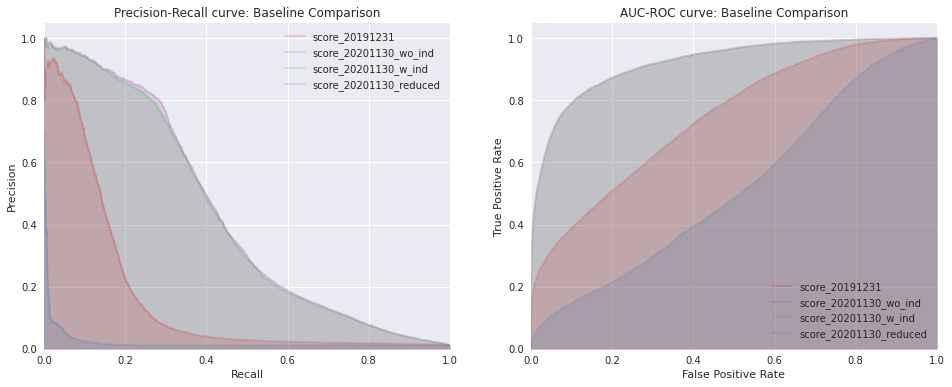

In [106]:
mntr_path = "./artifacts"
mntr.save_valid_performance_plots(
        {"20201201-reduced": df_}, "target", score_cols, mntr_path, dropna=True
    )

(570248, 108)

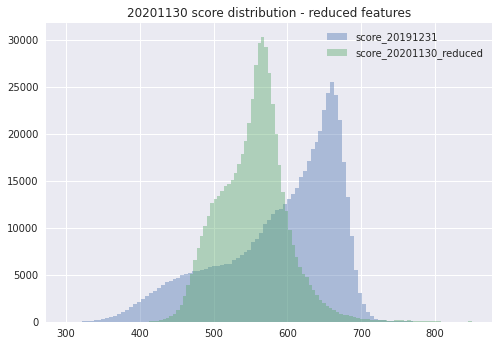

In [107]:
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_20201130_reduced"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)


plt.title("20201130 score distribution - reduced features")
plt.legend()

In [108]:
def plot_score_distr(df, ax, title):
    score_col = "score_20191231"
    df[score_col].hist(bins=50, alpha=0.4, label="incumbent_model", ax=ax)

    score_col = "score_20201130_reduced"
    df[score_col].hist(bins=50, alpha=0.4, label="refitted_model", ax=ax)
    
    ax.set_title(title)
    ax.legend()

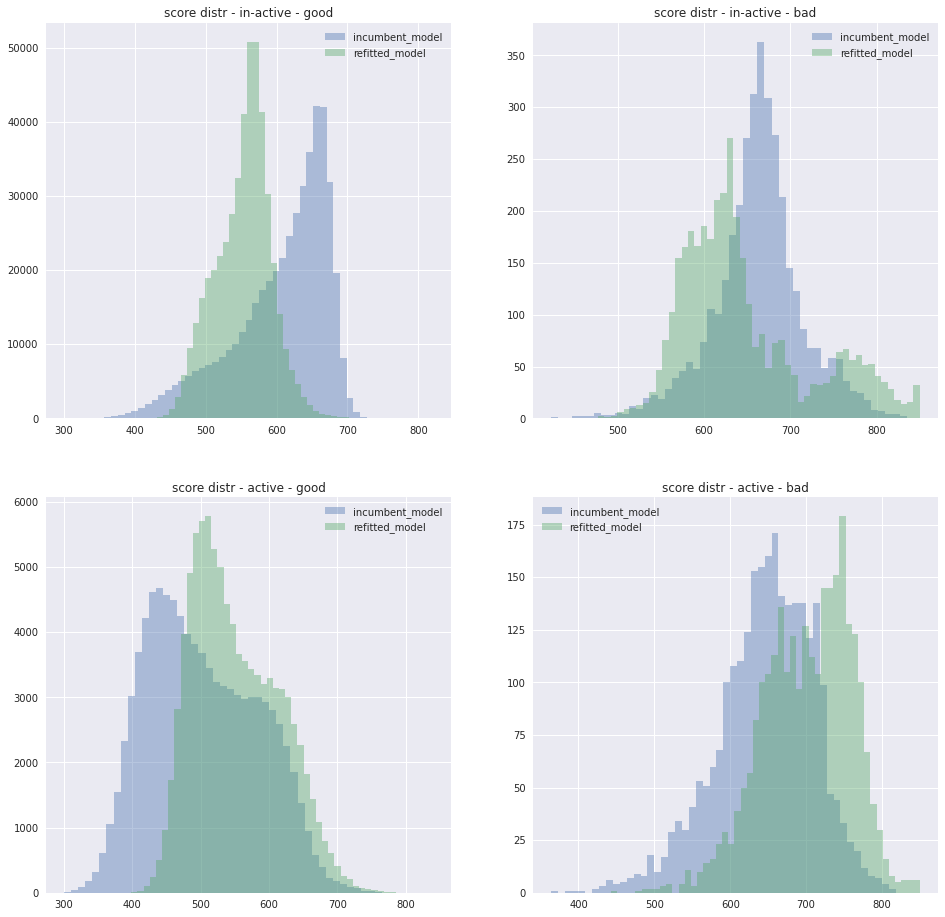

In [109]:
# plot 4x4
fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[~test_df.is_active & ~test_df.target]  # inactive good accounts
plot_score_distr(df_, axs[0, 0], "score distr - in-active - good")

df_ = test_df[~test_df.is_active & test_df.target]  # inactive bad accounts
plot_score_distr(df_, axs[0, 1], "score distr - in-active - bad")

df_ = test_df[test_df.is_active & ~test_df.target]  # active good accounts
plot_score_distr(df_, axs[1, 0], "score distr - active - good")

df_ = test_df[test_df.is_active & test_df.target]  # active bad accounts
plot_score_distr(df_, axs[1, 1], "score distr - active - bad")

plt.savefig("./artifacts/score_distr_reduced_n_target.png")

In [110]:
info = {"params": params,
        "scale_by_bad_rate": scale_by_bad_rate,
        "features": features_reduced,
        "indeterminate_col": indeterminate_col}

with open("artifacts/meta_data.json", "w") as f:
    json.dump(info, f, indent=4)
    
display(info)

{'params': {'objective': 'binary',
  'metric': 'auc',
  'boosting': 'gbdt',
  'num_iterations': 1400,
  'max_depth': 4,
  'num_leaves': 15,
  'learning_rate': 0.03,
  'feature_fraction': 0.8,
  'subsample': 0.94,
  'lambda_l1': 16,
  'lambda_l2': 10,
  'min_data_in_leaf': 116,
  'tree_learner': 'feature',
  'bagging_seed': 15556,
  'verbosity': 1,
  'seed': 15556,
  'categorical_feature': [39, 40, 41],
  'scale_pos_weight': 29.051314094798453},
 'scale_by_bad_rate': False,
 'features': ['address_risk_score',
  'age_money_account',
  'all7120',
  'all8220',
  'bcc7120',
  'credit_card_loan_amount',
  'dollar_val_dd',
  'dollar_val_returns',
  'dollar_val_returns_3d',
  'education_loan_amount',
  'email_risk_score',
  'first_deposit_amount',
  'fraud_score_1',
  'fraud_score_2',
  'giact_nr_decline',
  'giact_nr_other',
  'iln5520',
  'iqt9413',
  'iqt9415',
  'lag_acc_open_first_transaction',
  'name_address_correlation',
  'name_email_correlation',
  'name_phone_correlation',
  'nr_dir

## Summary/Notes
---
* Method 1: new ind def, drop during training
    * result similar to new ind def, refitted - not good enough
* Method 2: old ind def, drop during training
    * result similar to old ind def, refitted - not good enough
* **Promising** Method 3: kept ind during training
    * performance metric similar to the our score_20201130_w_ind_bad_rate option. The score distribution is better as the score_distribution is closer to the original model than the
* Method 4: kept ind during training, scaled by bad rate
    * no significant out-performance w.r.t. Method 3
* Method 5: kept ind during training, with 200 trees instead of 1400
    * Same as 5.1
* Method 5.1: kept ind during training, with 200 trees instead of 1400, scaled by bad rate
    * Slightly underperformed Method 3, and performance segmented by activeness does not behave well


* Method 6: dropped ind during training, with WOE monotonic constraints
* Method 7: dropped ind during trra